## Data

The data contains information collected from 54 Mica2Dot sensors deployed in the Intel Berkeley Research lab between February 28th and April 5th, 2004.  

Mica2Dot sensors with weather boards collected timestamped topology information, along with humidity, temperature, light and voltage values once every 31 seconds. 54 sensors were distributed throughout the laboratory. We will only look at the data for sensor 7.

<img src='layout.png'>

In [1]:
import datetime
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
%matplotlib inline

## Read the data

In [2]:
# Reading the data
df = pd.read_csv('input.csv')
df.head(10)

,ID,Date,Time,Epoch,MoteID,Temperature,Humidity,Light,Voltage
0,0,2004-02-28,01:05:16.649448,15,7,19.4298,38.9401,108.56,2.68742
1,1,2004-02-28,01:05:46.546353,16,7,19.4200,39.0763,104.88,2.67532
2,2,2004-02-28,01:06:16.766558,17,7,19.4298,39.1443,104.88,2.68742
3,3,2004-02-28,01:06:46.58428,18,7,19.4200,39.2123,104.88,2.68742
4,4,2004-02-28,01:07:16.511303,19,7,19.4200,39.2803,104.88,2.68742
5,5,2004-02-28,01:07:46.51801,20,7,19.4102,39.1443,104.88,2.68742
6,6,2004-02-28,01:08:16.046134,21,7,19.4200,39.1443,104.88,2.68742
7,7,2004-02-28,01:08:46.607604,22,7,19.4004,39.3483,104.88,2.68742
8,8,2004-02-28,01:09:16.530298,23,7,19.4004,39.3483,104.88,2.68742
9,9,2004-02-28,01:10:16.572357,25,7,19.3906,39.2463,104.88,2.68742


MotelID is the sensor location number, and epoch is a monotonically increasing time counter

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55361 entries, 0 to 55360
Data columns (total 9 columns):
ID             55361 non-null int64
Date           55361 non-null object
Time           55361 non-null object
Epoch          55361 non-null int64
MoteID         55361 non-null int64
Temperature    55354 non-null float64
Humidity       55354 non-null float64
Light          55354 non-null float64
Voltage        55361 non-null float64
dtypes: float64(4), int64(3), object(2)
memory usage: 3.8+ MB


In [4]:
df.isnull().sum()

ID             0
Date           0
Time           0
Epoch          0
MoteID         0
Temperature    7
Humidity       7
Light          7
Voltage        0
dtype: int64

## Wrangle and clean the data

In [5]:
# Merging the Date and Time columns to create a datetime/timestamp column
df['datetime'] = df['Date']+' '+df['Time']
df['datetime'] =pd.to_datetime(df['datetime'])

#filter dates
df = df[(df.datetime < pd.Timestamp(datetime.date(year=2004,month=3,day=23)))]

df = df.sort_values(by=['datetime'])


In [6]:
# Dropping the non-required columns from the data
df=df.drop('Date',axis=1)
df=df.drop('Time',axis=1)
df=df.drop('Epoch',axis=1)
df=df.drop('MoteID',axis=1)

In [7]:
# Cleaning the data of missing values
df=df.dropna()

In [8]:
df.head(10)

,ID,Temperature,Humidity,Light,Voltage,datetime
0,0,19.4298,38.9401,108.56,2.68742,2004-02-28 01:05:16.649448
1,1,19.4200,39.0763,104.88,2.67532,2004-02-28 01:05:46.546353
2,2,19.4298,39.1443,104.88,2.68742,2004-02-28 01:06:16.766558
3,3,19.4200,39.2123,104.88,2.68742,2004-02-28 01:06:46.584280
4,4,19.4200,39.2803,104.88,2.68742,2004-02-28 01:07:16.511303
5,5,19.4102,39.1443,104.88,2.68742,2004-02-28 01:07:46.518010
6,6,19.4200,39.1443,104.88,2.68742,2004-02-28 01:08:16.046134
7,7,19.4004,39.3483,104.88,2.68742,2004-02-28 01:08:46.607604
8,8,19.4004,39.3483,104.88,2.68742,2004-02-28 01:09:16.530298
9,9,19.3906,39.2463,104.88,2.68742,2004-02-28 01:10:16.572357


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43455 entries, 0 to 27740
Data columns (total 6 columns):
ID             43455 non-null int64
Temperature    43455 non-null float64
Humidity       43455 non-null float64
Light          43455 non-null float64
Voltage        43455 non-null float64
datetime       43455 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 2.3 MB


## Rolling median outlier detection

In [10]:
#set the constants you need
consistency_const = 1.4826
thresh = 3

#rolling median calculation
df['median_Humidity'] = df.Humidity.rolling(480,center=True).median()

#rolling MAD calculation
df['median_Humidity_diff'] = abs(df.Humidity-df.median_Humidity)
df['median_Humidity_mad'] = df.median_Humidity_diff.rolling(480,center=True).median()

#rolling modified z-score calculation
df['rolling_z_score'] = pd.to_numeric((df.median_Humidity_diff /(df.median_Humidity_mad*consistency_const)) > thresh)

In [11]:
df = df.dropna()

## Visualize results

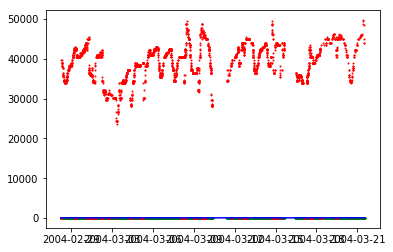

In [12]:
normal = df[df.rolling_z_score == 0]
anomaly = df[df.rolling_z_score == 1]

#normal data as green points
plt.plot_date(normal.datetime, normal.Humidity, color='green',markersize=0.5)
#anomalies as red points
plt.plot_date(anomaly.datetime, anomaly.Humidity, color='red',markersize=1)
#rolling median as blue line
plt.plot_date(df['datetime'],df['median_Humidity'], color='blue',linestyle='solid', marker='None')


Well it is not a surprise that these values are anomalous. They probably indicate sensor malfunction. Humidity can only range from 0 - 100. So lets filter these anomalies out

In [13]:
df = df[df.Humidity <100]
normal = df[df.rolling_z_score == 0]
anomaly = df[df.rolling_z_score == 1]

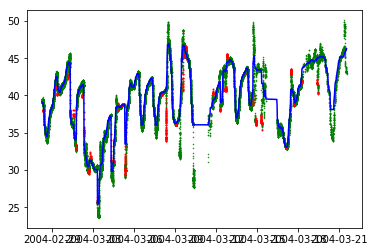

In [14]:
plt.plot_date(normal.datetime, normal.Humidity, color='green',markersize=0.5)
plt.plot_date(anomaly.datetime, anomaly.Humidity, color='red',markersize=1)
plt.plot_date(df['datetime'],df['median_Humidity'], color='blue',linestyle='solid', marker='None')

That looks nice. Big drops or spikes in humidity are flagged as anomalies. Perhaps we would want to use this to inform our cooling or heating systems to response and adjust the climate accordingly. Let's look at a two day period in detail:

(30, 50)

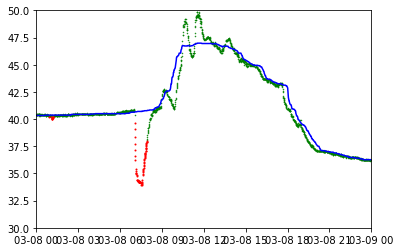

In [15]:
plt.plot_date(normal.datetime, normal.Humidity, color='green',markersize=0.5)
plt.plot_date(anomaly.datetime, anomaly.Humidity, color='red',markersize=1)
plt.plot_date(df['datetime'],df['median_Humidity'], color='blue',linestyle='solid', marker='None')

xmin = datetime.date(year=2004,month=3,day=8)
xmax = datetime.date(year=2004,month=3,day=9)
plt.xlim(xmin,xmax)
plt.ylim(30,50)

The sudden drop near the beggining is flagged as anomalous. But smaller drops near the begginging are also flagged. Why is this? Well remember anomalies are defined relative the the variabilty around that time (using our moving MAD). Because variabilty at the start of this period is low, small changes are flagged as anomalies